In [16]:
%reset -f

import pandas as pd
import numpy as np
# import folium   
import os
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import AutoLocator
import seaborn as sns

In [17]:
import geopandas as gpd
from bokeh.plotting import figure, output_notebook, show
output_notebook()
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool, WheelZoomTool, WMTSTileSource
from bokeh.palettes import Viridis256

def plot_geo_scatter_map(df, value_col, title="Geo Map", colorbar_title="Value", unit=""):
    # Create GeoDataFrame and project to Web Mercator
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326").to_crs("EPSG:3857")
    gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(gdf['x'].min()-300, gdf['x'].max()+300),
        y_range=(gdf['y'].min()-300, gdf['y'].max()+300)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    color_mapper = LinearColorMapper(palette=Viridis256, low=gdf[value_col].min(), high=gdf[value_col].max())
    source = ColumnDataSource(gdf[['x', 'y', value_col, 'Latitude', 'Longitude']])

    # Scatter points
    p.scatter(
        x='x', y='y', size=5, source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat/Lon", "@{Latitude}, @{Longitude}"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

Loading BokehJS ...

In [18]:
df_app_capacity = pd.read_csv('../_data/Spring2025_ArkansasNH/app_capacity.csv')
df_app_capacity = df_app_capacity[df_app_capacity['Test Status'] == 'Completed']
df_app_capacity['Calculated Tput (Mbps)'] = (df_app_capacity['Bytes Transferred']*8) / (df_app_capacity['Duration']*1e6)

df_app_dl = df_app_capacity[df_app_capacity['Direction'] == 'Downlink']
df_app_ul = df_app_capacity[df_app_capacity['Direction'] == 'Uplink']

In [19]:
print(df_app_capacity['Collection'].value_counts())

Collection
Day1-TMO-MNO-DEF-IN       92
Day2-ATT-MNO-DEF-OUT      71
Day1-TMO-NH-IN            71
Day1-TMO-MNO-DEF-OUT      63
Day2-TMO-MNO-4G-OUT       58
Day2-TMO-MNO-4G-IN        57
Day2-VZN-MNO-4G-OUT       55
Day2-ATT-MNO-4G-IN        52
Day2-TMO-MNO-DEF-OUT      50
Day2-ATT-MNO-DEF-IN       50
Day1-ATT-MNO-DEF-IN       50
Day3_TMO-NH-L1            48
Day2-ATT-MNO-4G-OUT       48
Day1-ATT-MNO-DEF-OUT      43
Day2-VZN-MNO-DEF-IN       43
Day2-VZN-MNO-4G-IN        42
Day1-ATT-NH-IN            41
Day2-VZN-MNO-DEF-OUT      38
Day2-TMO-MNO-DEF-OUTER    37
Day2-ATT-MNO-DEF-OUTER    37
Day2-TMO-MNO-DEF-IN       36
Day2-VZN-MNO-DEF-OUTER    36
Day3_ATT-MNO-DEF-IN-L1    33
Day1-WIFI-IN              30
Day3_ATT-MNO-DEF-IN-L2    30
Day3_ATT-NH-IN-L2         30
Day3_TMO-DEF-L1-V1        28
Day3_TMO-NH-L2            20
Day3_ATT-NH-IN-L1         17
Day1-WIFI-OUT             16
Day3_TMO-DEF-IN-L2        14
Day3_TMO-DEF-L2           10
Day3_unnamed               8
Day1-ATT-NH-OUT            7
Day

In [20]:
df_app_dl['Collection_1'] = np.nan

df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-ATT-NH-IN']), 'ATT-NH-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-NH-IN']), 'TMO-NH-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-ATT-MNO-DEF-OUT', 'Day2-ATT-MNO-4G-OUT', 'Day1-ATT-MNO-DEF-OUT']), 'ATT-MNO-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-MNO-DEF-OUT', 'Day2-TMO-MNO-4G-OUT', 'Day2-TMO-MNO-DEF-OUT']), 'TMO-MNO-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-VZN-MNO-4G-OUT', 'Day2-VZN-MNO-DEF-OUT']), 'VZN-MNO-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-ATT-MNO-4G-IN', 'Day2-ATT-MNO-DEF-IN', 'Day1-ATT-MNO-DEF-IN']), 'ATT-MNO-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-MNO-DEF-IN', 'Day2-TMO-MNO-4G-IN', 'Day2-TMO-MNO-DEF-IN']), 'TMO-MNO-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-VZN-MNO-DEF-IN', 'Day2-VZN-MNO-4G-IN']), 'VZN-MNO-IN', df_app_dl['Collection_1'])

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_52581/645870935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_dl['Collection_1'] = np.nan
/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_52581/645870935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_dl['Collection_1'])
/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_52581/645870935.py:4: SettingWithCopyWarn

In [ ]:
df_app_ul['Collection_1'] = np.nan

df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-ATT-NH-IN']), 'ATT-NH-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-NH-IN']), 'TMO-NH-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-ATT-MNO-DEF-OUT', 'Day2-ATT-MNO-4G-OUT', 'Day1-ATT-MNO-DEF-OUT']), 'ATT-MNO-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-MNO-DEF-OUT', 'Day2-TMO-MNO-4G-OUT', 'Day2-TMO-MNO-DEF-OUT']), 'TMO-MNO-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-VZN-MNO-4G-OUT', 'Day2-VZN-MNO-DEF-OUT']), 'VZN-MNO-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-ATT-MNO-4G-IN', 'Day2-ATT-MNO-DEF-IN', 'Day1-ATT-MNO-DEF-IN']), 'ATT-MNO-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-MNO-DEF-IN', 'Day2-TMO-MNO-4G-IN', 'Day2-TMO-MNO-DEF-IN']), 'TMO-MNO-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-VZN-MNO-DEF-IN', 'Day2-VZN-MNO-4G-IN']), 'VZN-MNO-IN', df_app_ul['Collection_1'])

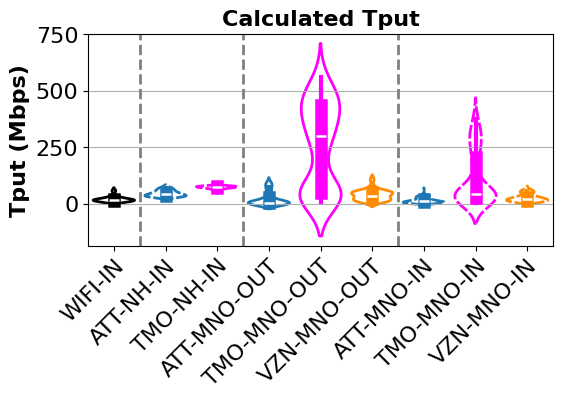

In [21]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'ATT-NH-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'tab:blue', 'magenta', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
for i in [1,2,6,7,8]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Calculated Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

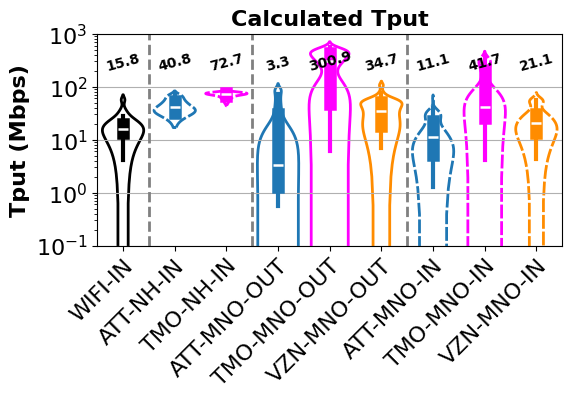

In [22]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'ATT-NH-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'tab:blue', 'magenta', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)

medians = df_app_dl.groupby('Collection_1')['Calculated Tput (Mbps)'].median()
for i, collection in enumerate(['WIFI-IN', 'ATT-NH-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']):
    median_value = medians[collection]
    ax.text(i, 2e2, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

for i in [1,2,6,7,8]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Calculated Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
plt.yscale('log')
plt.ylim(1e-1, 1e3)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

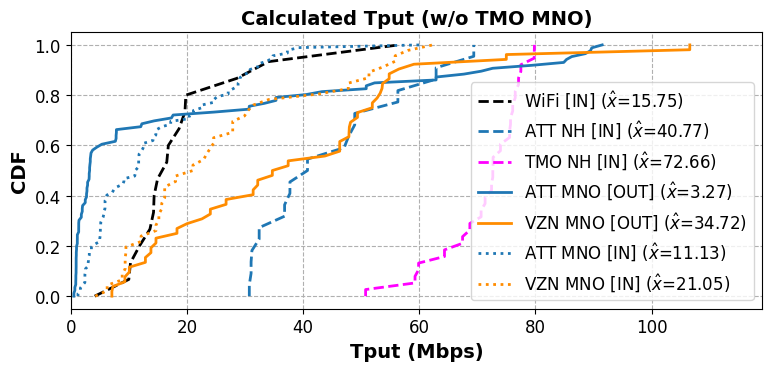

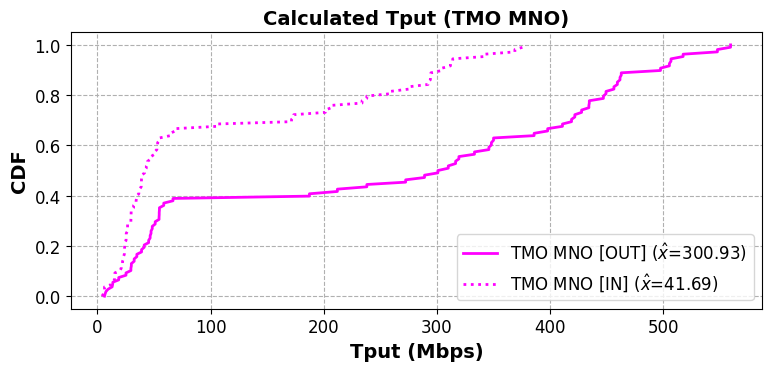

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[df_app_dl['Collection_1']=='WIFI-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='black')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='ATT-NH-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT NH [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='tab:blue')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-NH-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO NH [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='ATT-MNO-OUT']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:blue')
del df_temp

# df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-OUT']["Calculated Tput (Mbps)"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"TMO MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='solid', color='magenta')
# del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='VZN-MNO-OUT']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='darkorange')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='ATT-MNO-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='tab:blue')
del df_temp

# df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"TMO MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='dotted', color='magenta')
# del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='VZN-MNO-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='darkorange')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (w/o TMO MNO)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.xlim(0, 119)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-OUT']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-IN']["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='magenta')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (TMO MNO)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

Technology  Data Technology Summary
LTE         LTE CA                      3
            LTE/LTE CA                 20
Name: count, dtype: int64
Technology  Data Technology Summary
LTE         LTE CA                      1
            LTE/LTE CA                 38
Name: count, dtype: int64


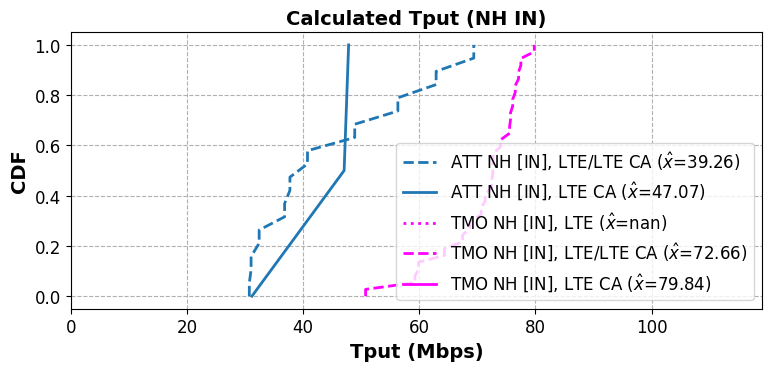

In [24]:
print(df_app_dl[df_app_dl['Collection_1']=='ATT-NH-IN'][['Technology', 'Data Technology Summary']].value_counts().sort_index())
print(df_app_dl[df_app_dl['Collection_1']=='TMO-NH-IN'][['Technology', 'Data Technology Summary']].value_counts().sort_index())

fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[(df_app_dl['Collection_1']=='ATT-NH-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT NH [IN], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='tab:blue')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='ATT-NH-IN') & (df_app_dl['Data Technology Summary']=='LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT NH [IN], LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:blue')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-NH-IN') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO NH [IN], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-NH-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO NH [IN], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-NH-IN') & (df_app_dl['Data Technology Summary']=='LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO NH [IN], LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (NH IN)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.xlim(0, 119)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

Technology  Data Technology Summary
LTE         LTE                        33
            LTE/LTE CA                 54
Name: count, dtype: int64
Technology  Data Technology Summary
5G NR       5G NR                       7
            5G NR/5G NR CA             68
LTE         LTE/LTE CA                 34
Name: count, dtype: int64
Technology  Data Technology Summary
LTE         LTE                         3
            LTE-5G NR                  12
            LTE/LTE CA                 30
            LTE/LTE-5G NR               8
Name: count, dtype: int64


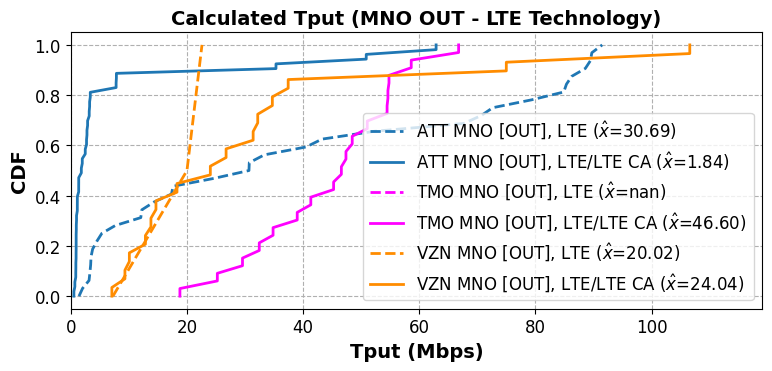

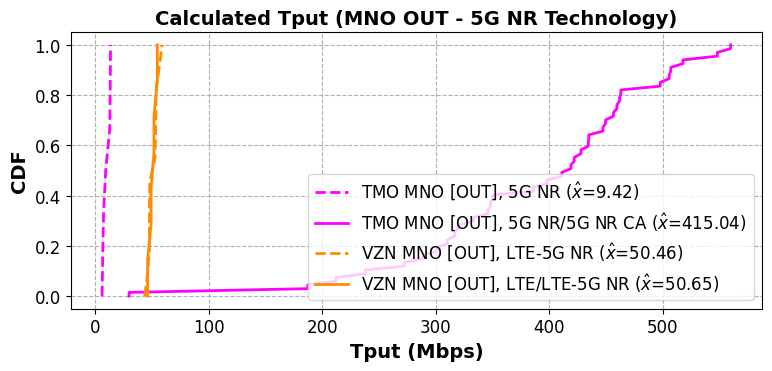

In [25]:
print(df_app_dl[df_app_dl['Collection_1']=='ATT-MNO-OUT'][['Technology', 'Data Technology Summary']].value_counts().sort_index())
print(df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-OUT'][['Technology', 'Data Technology Summary']].value_counts().sort_index())
print(df_app_dl[df_app_dl['Collection_1']=='VZN-MNO-OUT'][['Technology', 'Data Technology Summary']].value_counts().sort_index())

fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[(df_app_dl['Collection_1']=='ATT-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [OUT], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='tab:blue')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='ATT-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [OUT], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:blue')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [OUT], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [OUT], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [OUT], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='darkorange')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [OUT], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='darkorange')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (MNO OUT - LTE Technology)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.xlim(0, 119)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-OUT') & (df_app_dl['Data Technology Summary']=='5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [OUT], 5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-OUT') & (df_app_dl['Data Technology Summary']=='5G NR/5G NR CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [OUT], 5G NR/5G NR CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE-5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [OUT], LTE-5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='darkorange')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-OUT') & (df_app_dl['Data Technology Summary']=='LTE/LTE-5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [OUT], LTE/LTE-5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='darkorange')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (MNO OUT - 5G NR Technology)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

Technology  Data Technology Summary
LTE         LTE                        25
            LTE/LTE CA                 68
Name: count, dtype: int64
Technology  Data Technology Summary
5G NR       5G NR                       2
            5G NR/5G NR CA             60
LTE         LTE-5G NR                   2
            LTE/LTE CA                 34
            LTE/LTE CA/LTE-5G NR        3
            LTE/LTE-5G NR               8
Name: count, dtype: int64
Technology  Data Technology Summary
LTE         LTE                         1
            LTE-5G NR                  11
            LTE/LTE CA                 24
            LTE/LTE CA/LTE-5G NR        9
            LTE/LTE-5G NR               2
Name: count, dtype: int64


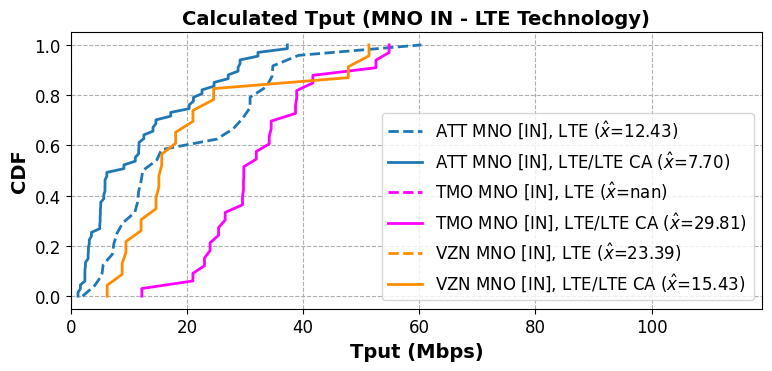

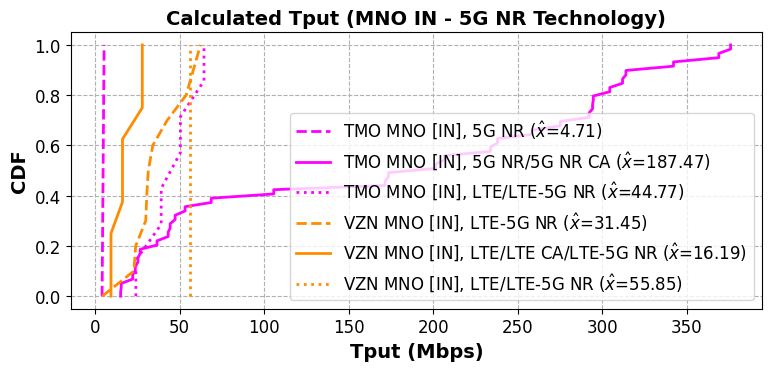

In [26]:
print(df_app_dl[df_app_dl['Collection_1']=='ATT-MNO-IN'][['Technology', 'Data Technology Summary']].value_counts().sort_index())
print(df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-IN'][['Technology', 'Data Technology Summary']].value_counts().sort_index())
print(df_app_dl[df_app_dl['Collection_1']=='VZN-MNO-IN'][['Technology', 'Data Technology Summary']].value_counts().sort_index())

fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[(df_app_dl['Collection_1']=='ATT-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [IN], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='tab:blue')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='ATT-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [IN], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:blue')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN], LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='darkorange')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN], LTE/LTE CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='darkorange')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (MNO IN - LTE Technology)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.xlim(0, 119)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-IN') & (df_app_dl['Data Technology Summary']=='5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN], 5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-IN') & (df_app_dl['Data Technology Summary']=='5G NR/5G NR CA')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN], 5G NR/5G NR CA ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='TMO-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE-5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN], LTE/LTE-5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='magenta')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE-5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN], LTE-5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='darkorange')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE CA/LTE-5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN], LTE/LTE CA/LTE-5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='darkorange')
del df_temp

df_temp = df_app_dl[(df_app_dl['Collection_1']=='VZN-MNO-IN') & (df_app_dl['Data Technology Summary']=='LTE/LTE-5G NR')]["Calculated Tput (Mbps)"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN], LTE/LTE-5G NR ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='darkorange')
del df_temp

ax.set_xlabel('Tput (Mbps)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Calculated Tput (MNO IN - 5G NR Technology)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
# plt.xlim(0, 119)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

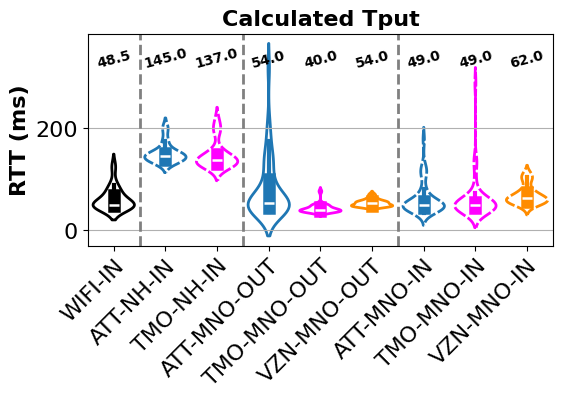

In [27]:
# Application Round Trip Time
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'ATT-NH-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'tab:blue', 'magenta', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Round Trip Time', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
for i in [1,2,6,7,8]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
medians = df_app_dl.groupby('Collection_1')['Round Trip Time'].median()
for i, collection in enumerate(['WIFI-IN', 'ATT-NH-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']):
    median_value = medians[collection]
    ax.text(i, 320, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
# labels = plt.gca().get_xticklabels()
# for label in labels:
#     if label.get_text() in ['NH-b48-IN', 'MNO_A-n77-IN', 'MNO_B-n41-IN']:
#         label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RTT (ms)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
plt.title('Calculated Tput', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

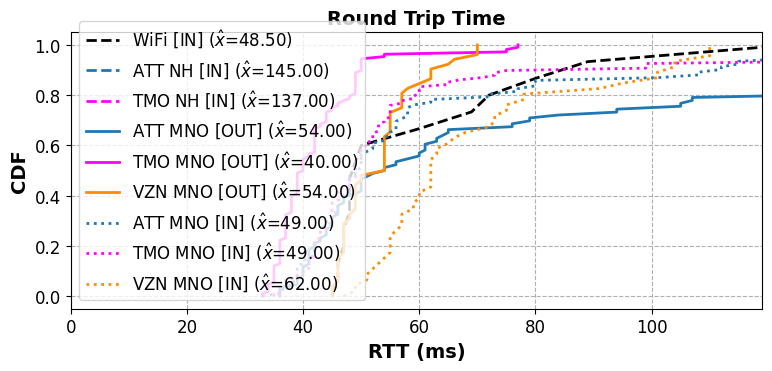

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams['text.usetex'] = False 

df_temp = df_app_dl[df_app_dl['Collection_1']=='WIFI-IN']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"WiFi [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='black')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='ATT-NH-IN']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT NH [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='tab:blue')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-NH-IN']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO NH [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='magenta')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='ATT-MNO-OUT']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:blue')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-OUT']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='magenta')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='VZN-MNO-OUT']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='darkorange')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='ATT-MNO-IN']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"ATT MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='tab:blue')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='TMO-MNO-IN']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"TMO MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='magenta')
del df_temp

df_temp = df_app_dl[df_app_dl['Collection_1']=='VZN-MNO-IN']["Round Trip Time"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"VZN MNO [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dotted', color='darkorange')
del df_temp

ax.set_xlabel('RTT (ms)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('Round Trip Time', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.xlim(0, 119)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower left')
plt.tight_layout()
plt.show()